In [79]:
import matplotlib.pyplot as plt
import srt_util
import PhysicsTool as pt
import numpy as np

In [80]:
def plot_elevation_scan(file_path):
    with srt_util.SRT_HDF_Reader(file_path) as srt_reader:
        pos = srt_reader.get_object_positions()
        spec = srt_reader.get_power_spectrum()
        print('Start of measurement: ', srt_reader.get_time()[0])
    azimut = int(pos['Azimuth'][0])
    plt.plot(pos['Elevation'], spec.sum(axis=1), label = f'Azimut = {azimut}°', marker='o')

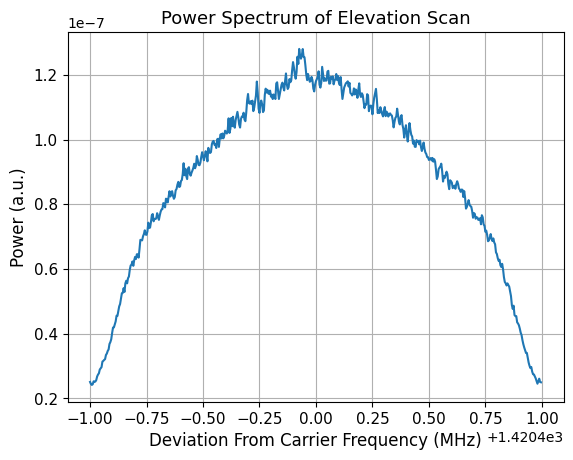

In [ ]:
# with srt_util.SRT_HDF_Reader('Measurements/ElevationScan/ElevationScan_T2220_Az180_20251001.hdf') as srt_reader:
#     spec = srt_reader.get_power_spectrum()
#     pt.plotting.start_plot('Power Spectrum of Elevation Scan', 'Deviation From Carrier Frequency (MHz)', 'Power (a.u.)')
#     # Tell Matplotlib to use offset/scientific notation
#     plt.plot(srt_util.SPECTROMETER_FREQUENCIES / 1e6,spec[0])
#     plt.xticks(srt_util.SPECTROMETER_XTICKS)
#     plt.ticklabel_format(axis='x', style='sci', useOffset=srt_util.CARRIER_FREQ/1e6)

Start of measurement:  2025-10-01T20:28:52
Start of measurement:  2025-10-01T20:23:33


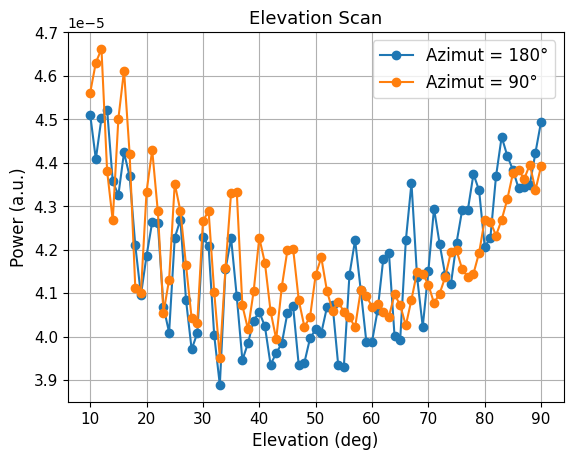

In [82]:
pt.plotting.start_plot(f'Elevation Scan', 'Elevation (deg)', 'Power (a.u.)')
plot_elevation_scan('Measurements/ElevationScan/ElevationScan_T2220_Az180_20251001.hdf')
plot_elevation_scan('Measurements/ElevationScan/ElevationScan_T2220_Az90_20251001.hdf')
pt.plotting.end_plot()

Start of measurement:  2025-10-01T20:40:22
Start of measurement:  2025-10-01T20:34:40


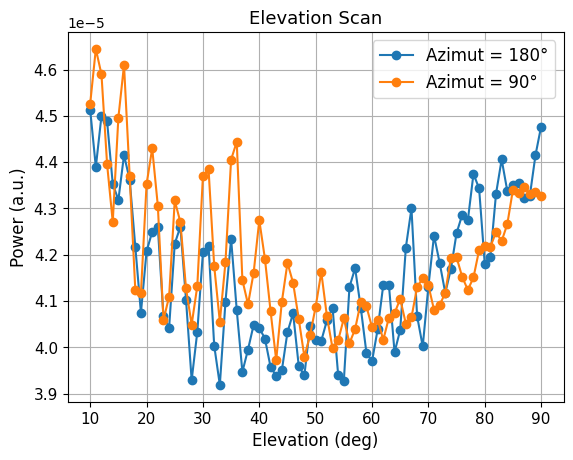

In [83]:
pt.plotting.start_plot(f'Elevation Scan', 'Elevation (deg)', 'Power (a.u.)')
plot_elevation_scan('Measurements/ElevationScan/ElevationScan_T2235_Az180_20251001.hdf')
plot_elevation_scan('Measurements/ElevationScan/ElevationScan_T2235_Az90_20251001.hdf')
pt.plotting.end_plot()